source : https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

Autosave disabled


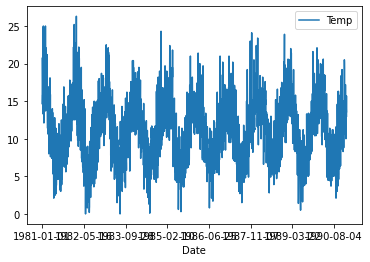

In [5]:
%autosave 0

from pandas import read_csv
from matplotlib import pyplot
series = read_csv('daily-min-temperatures.csv', header=0, index_col=0)
series.plot();

In [11]:
series.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [15]:
series.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


# Autocorrelation

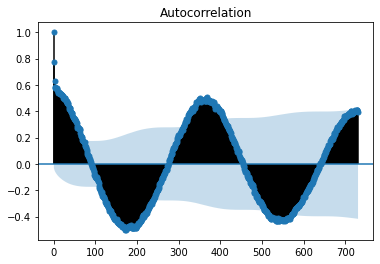

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=365*2);

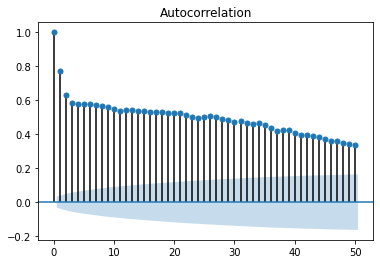

In [22]:
plot_acf(series, lags=50);

=> we can see seasons in this plot (positive/negative correlations accros season winter/summer)

# Autocorrelation partielle

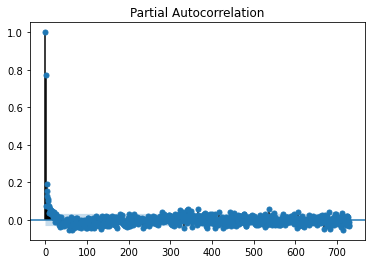

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(series, lags=365*2);

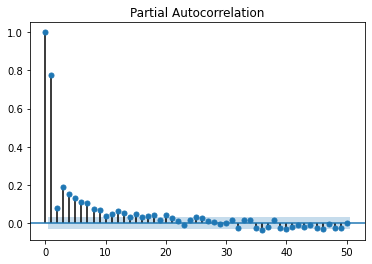

In [24]:
plot_pacf(series, lags=50);

# Modèle persistent (baseline)

Test MSE: 3.423


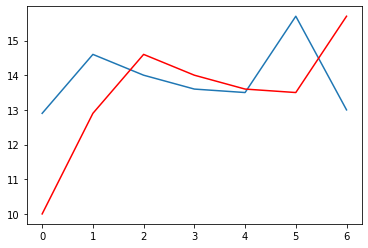

In [25]:
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
# create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red');

# Modèle d'autorégression

Lag: [1 2 3 4 5 6 7]
Coefficients: [ 1.1171522   0.62645825 -0.07504654  0.07384666  0.06208368  0.06561174
  0.04428808  0.10242029]
predicted=11.549744, expected=12.900000
predicted=12.495221, expected=14.600000
predicted=12.703069, expected=14.000000
predicted=12.449430, expected=13.600000
predicted=12.226329, expected=13.500000
predicted=12.180301, expected=15.700000
predicted=11.893612, expected=13.000000
Test MSE: 3.499


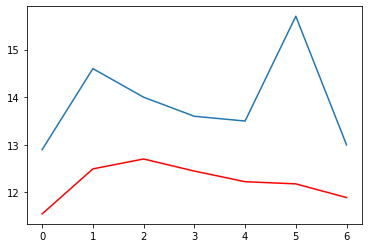

In [30]:
from statsmodels.tsa.ar_model import AutoReg
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AutoReg(train, lags=7)
model_fit = model.fit()
print('Lag: %s' % model.ar_lags)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red');

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test MSE: 1.451


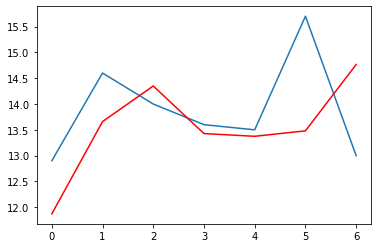

In [33]:
from statsmodels.tsa.ar_model import AR
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red');